In [1]:
# Use random forest regression to predict crypto price behavior based on Tweet sentiment (with added text preprocessing)

In [2]:
# import packages
import snscrape.modules.twitter as sntwitter
import pandas as pd
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import requests
from datetime import datetime, timedelta
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
from nltk.tokenize import word_tokenize

In [3]:
# initializing preprocessing variables
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english", ignore_stopwords=True)
lemmatizer = WordNetLemmatizer()

In [4]:
# create a function to remove emojis
def no_emojis(tweet):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r' ',tweet)

In [5]:
#create a function to clean the tweets
def clean_tweet(tweet):
    tweet = tweet.lower() #removes capitalization
    tweet = re.sub('#ethereum', 'ethereum', tweet) #changes #ethereum to ethereum
    tweet = re.sub('#[A-Za-z0-9]+', '', tweet) #removes any other string that comes after a hashtag
    tweet = re.sub('\\n', '', tweet) #removes the newline character
    tweet = re.sub('https?:\/\/\S+', '', tweet) #removes hyperlinks
    tweet = re.sub('@[^\s]+','',tweet) #removes usernames
    tweet = no_emojis(tweet) #removes emojis
    tweet = word_tokenize(tweet) #tokenizes the tweets
    tweet = [lemmatizer.lemmatize(t) for t in tweet if t not in stop_words] #lemmatizes the tweets
    tweet = ' '.join([stemmer.stem(i) for i in tweet]) #stems the tweets and joins them in a string
    return tweet

In [6]:
#create a function to get the text sentiment based on polarity
def get_sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [7]:
# Creating list to append tweet data to
tweets = []
def run_the_tweets(tweet):
    cleaned_tweets = clean_tweet(tweet.content)
    tweet_subjectivity = TextBlob(cleaned_tweets).sentiment.subjectivity
    tweet_polarity = TextBlob(cleaned_tweets).sentiment.polarity
    sentiment_score = get_sentiment(tweet_polarity)
    tweets.append([tweet.content, tweet.date, cleaned_tweets, sentiment_score, tweet_subjectivity, tweet_polarity])

In [8]:
# create an empty data frame with a list of dates as index starting on the current date 
today = datetime.now() + timedelta(hours=5) #adding 5 hours to match UTC time
month_ago = today - timedelta(days = 30)
today = today.strftime('%Y-%m-%d')
month_ago = month_ago.strftime('%Y-%m-%d')
df = pd.date_range(month_ago, today)

In [9]:
# create a function to get the current day's tweets
def final_day():
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper('ethereum exclude:retweets').get_items()):
        if i>1:
            break
        run_the_tweets(tweet)

In [10]:
# Using TwitterSearchScraper to scrape data and append tweets to list
i=0
x=0
first_date = df[x].strftime('%Y-%m-%d')
second_date = df[x+1].strftime('%Y-%m-%d')
for x in range(30):
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper('ethereum exclude:retweets since:'+first_date+' until:'+second_date).get_items()):
        if i>1:
            break
        if x<30:
            first_date = df[x].strftime('%Y-%m-%d')
            second_date = df[x+1].strftime('%Y-%m-%d')
        elif x == 30:
            final_day() 
            break
        else:
            break
        run_the_tweets(tweet)
        i+=1
        x+=1

In [11]:
# Creating a dataframe from the tweets list above
tweets = pd.DataFrame(tweets, columns=['Text', 'Date', 'Cleaned Tweets', 'Sentiment', 'Subjectivity', 'Polarity'])

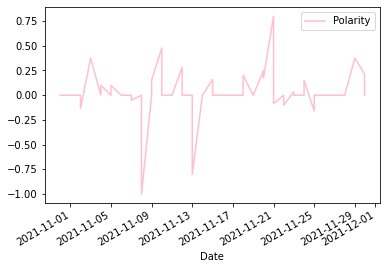

In [12]:
# graphing polarity of tweets over 30 days
sentiment_graph = tweets.plot.line(x='Date', y='Polarity', color='pink')

In [13]:
# create a new data frame with only polarity and grouping the remaining number values
polarity = tweets.drop('Subjectivity', 1)
sentiment = polarity.set_index('Date').groupby(pd.Grouper(freq='d')).mean()

In [14]:
# calling the Crypto Compare API to return Ethereum prices for the last 30 days
def get_crypto_price(symbol, exchange, day):
    api_key = 'eeda2dcaa0edbb8bd14f77f682c79e556d34af4e17099c41261c49bc125c9c3b'
    api_url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={symbol}&tsym={exchange}&limit={day}&api_key={api_key}'
    raw = requests.get(api_url).json()
    df = pd.DataFrame(raw['Data']['Data'])[['time', 'close']].set_index('time')
    df.index = pd.to_datetime(df.index, unit = 's')
    return df
#create a data frame with the prices
eth = get_crypto_price('ETH', 'USD', 30)

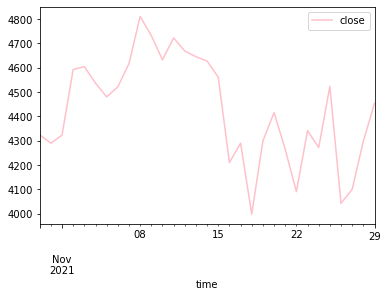

In [15]:
#graph the prices
line_graph = eth.plot.line(color='pink')

In [16]:
#creating new Ethereum price dataframe with the correct timezone
eth1 = eth.copy()
eth1.index = eth.index.tz_localize('UTC')

In [17]:
# combining dataframe values
combined_df = pd.DataFrame({'Date': df[0], 'Polarity' : sentiment['Polarity'], 'Close Price' : eth1['close']})

In [18]:
# setting up a random forest regression model
x = combined_df.iloc[:, 1:2].values 
y = combined_df.iloc[:, 2].values
regressor = RandomForestRegressor(n_estimators = 200, random_state = 0)
regressor.fit(x, y)  
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
Y_pred1 =regressor.predict(X_test)

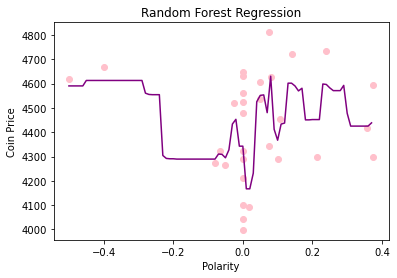

In [19]:
#plot the preojected and real data for the regression model
Y_pred = regressor.predict(np.array([6.5]).reshape(1, 1))
X_grid = np.arange(min(x), max(x), 0.01)             
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(x, y, color = 'pink')  
plt.plot(X_grid, regressor.predict(X_grid), 
         color = 'purple') 
plt.title('Random Forest Regression')
plt.xlabel('Polarity')
plt.ylabel('Coin Price')
plt.show()

In [20]:
#printing error data
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, Y_pred1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, Y_pred1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, Y_pred1)))

Mean Absolute Error: 98.9149043919055
Mean Squared Error: 18953.102440880564
Root Mean Squared Error: 137.67026709090297
